In [ ]:
%config InlineBackend.figure_format = 'retina'  #To get figures with high quality!

import numpy as np
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

torch.manual_seed(0)
np.random.seed(0)

# DATASET: FashionMNIST
FashionMNIST es un conjunto de datos de imágenes utilizado para tareas de clasificación en aprendizaje automático.
- Contiene 70,000 imágenes en escala de grises de 28x28 píxeles.
- Cada imagen representa una prenda de ropa, como camisetas, pantalones, zapatos, etc.
- Hay 10 clases diferentes, cada una correspondiente a un tipo de prenda.
- El dataset está dividido en 60,000 imágenes para entrenamiento y 10,000 para prueba.
- Es una alternativa moderna al clásico MNIST (dígitos escritos a mano), proporcionando un reto mayor para los modelos de clasificación.

Las clases de FashionMNIST son:
0: T-shirt/top (Camiseta/Top)
1: Trouser (Pantalón)
2: Pullover (Jersey/Suéter)
3: Dress (Vestido)
4: Coat (Abrigo)
5: Sandal (Sandalia)
6: Shirt (Camisa)
7: Sneaker (Zapatilla deportiva)
8: Bag (Bolso)
9: Ankle boot (Bota corta)

In [ ]:
# Usamos transforms.ToTensor() para convertir las imágenes a tensores de PyTorch
# y transforms.Normalize() para normalizar los valores de píxeles a la media 0 y desviación estándar 1.
# el rango original [0, 1] pasa a [-1, 1].
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_data = datasets.FashionMNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

# Creamos los DataLoader para cargar los datos en lotes (batches) durante el entrenamiento y la evaluación.
# El DataLoader mezcla (shuffle) los datos de entrenamiento para mejorar el aprendizaje, pero no los de prueba.
train_loader_FMNIST = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader_FMNIST = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

In [ ]:
# Usamos transforms.ToTensor() para convertir las imágenes a tensores de PyTorch
# y transforms.Normalize() para normalizar los valores de píxeles a la media 0 y desviación estándar 1.
# el rango original [0, 1] pasa a [-1, 1].
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5), (0.5))
])

train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Creamos los DataLoader para cargar los datos en lotes (batches) durante el entrenamiento y la evaluación.
# El DataLoader mezcla (shuffle) los datos de entrenamiento para mejorar el aprendizaje, pero no los de prueba.
train_loader_MNIST = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader_MNIST = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=False, num_workers=2)

100%|██████████| 9.91M/9.91M [00:01<00:00, 6.28MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 311kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.36MB/s]
100%|██████████| 4.54k/4.54k [00:00<?, ?B/s]


In [ ]:
# Verificamos el número de batches en el DataLoader de entrenamiento
n_batches = 0
for images, labels in train_loader_MNIST:
    n_batches += 1
print(n_batches, len(train_loader_MNIST))


938 938


In [ ]:
# Obtenemos un batch de datos para conocer su dimensión
images, labels = next(iter(train_loader_FMNIST))
print(images.shape, labels.shape)

# images: a tensor containing all the images in this batch. Shape (batch_size, 1, 28, 28)
#       - 64 images in the batch
#       - 1 channel (grayscale)
#       - each image is 28x28 pixels

torch.Size([64, 1, 28, 28]) torch.Size([64])


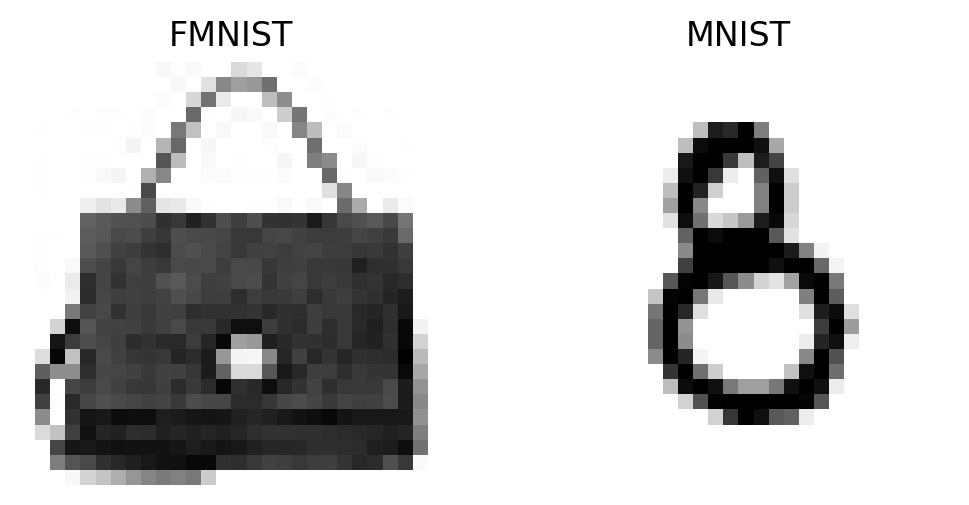

In [ ]:
# Visualización de una imagen del batch
# - images[0]: la primera imagen del lote.
# - .numpy(): convierte el tensor de PyTorch a un array de NumPy.
# - .squeeze(): elimina dimensiones de tamaño 1 (de (1, 28, 28) a (28, 28)).
# - cmap='gray_r': usa un mapa de colores en escala de grises, invertido (0 es blanco y 1 es negro).

def rescale(img):
    # Desnormaliza: si tus datos están normalizados en [-1, 1],
    # esto los lleva de nuevo al rango [0, 1] (visible como imagen)
    img = img / 2 + 0.5

    # Convierte el tensor a array de NumPy
    npimg = img.numpy()

    # Cambia el orden de ejes de (C, H, W) a (H, W, C),
    # que es lo que matplotlib espera
    return np.transpose(npimg, (1, 2, 0))

fig, axs = plt.subplots(1, 2, figsize=(6, 3))

# FMNIST
traindata = iter(train_loader_FMNIST)
images, labels = next(traindata)
axs[0].imshow(rescale(images[0]),cmap='gray_r')
axs[0].set_title(f"FMNIST")
axs[0].axis("off")

# MNIST
traindata = iter(train_loader_MNIST)
images, labels = next(traindata)
axs[1].imshow(rescale(images[0]),cmap='gray_r')
axs[1].set_title(f"MNIST")
axs[1].axis("off")

plt.show()


In [ ]:
import torch.nn as nn
from torch import optim
import time

# Arquitectura simétrica: 3 capas en encoder y 3 en decoder
class ConvAutoencoder(nn.Module):
    def __init__(self, C=4,dropout_prob=0.5):
        super().__init__()

        # Encoder: 3 capas convolucionales + 3 capas de pooling
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=C, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)

        # Decoder: 3 capas deconvolucionales (transposed conv)
        self.t_conv1 = nn.ConvTranspose2d(C, 64, kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.conv4 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)

        # BatchNorm opcional para cada capa
        self.BN_1 = nn.BatchNorm2d(32)
        self.BN_2 = nn.BatchNorm2d(64)
        self.BN_3 = nn.BatchNorm2d(C)
        self.BN_4 = nn.BatchNorm2d(64)
        self.BN_5 = nn.BatchNorm2d(32)

        self.relu = nn.ReLU()
        self.decoder_activation = nn.Tanh() # Para imágenes normalizadas entre -1 y 1
        self.droput = nn.Dropout2d(p=dropout_prob) # Dropout para capas del encoder

    def forward(self, x):
        # Encoder
        #Capa 1
        x = self.conv1(x)   # 28x28x16
        x = self.BN_1(x)
        x = self.relu(x)    # 28x28x16
        x = self.pool(x)    # 14x14x16
        x = self.droput(x)
        # Capa 2
        x = self.conv2(x)   # 14x14x32
        x = self.BN_2(x)
        x = self.relu(x)    # 14x14x32
        x = self.pool(x)    # 7x7x32
        x = self.droput(x)
        # Capa 3
        x = self.conv3(x)   # 7x7xC
        x = self.BN_3(x)
        x = self.relu(x)    # 7x7xC

        latent = x

        # Decoder
        # Capa 1
        x = self.t_conv1(x) # 7x7x32
        x = self.BN_4(x)
        x = self.relu(x)    # 7x7x32
        x = self.droput(x)
        # Capa 2
        x = self.t_conv2(x) # 14x14x16
        x = self.BN_5(x)
        x = self.relu(x)    # 14x14x16
        # Capa 3
        x = self.conv4(x) # 28x28x1
        x = self.decoder_activation(x)

        return x, latent

In [ ]:
def psnr(y_true_norm, y_pred_norm):
    """
    Calcula el PSNR para tensores en rango [-1, 1].
    """
    # Re-escala de [-1, 1] a [0, 1]
    y_true = (y_true_norm / 2) + 0.5
    y_pred = (y_pred_norm / 2) + 0.5

    # MAX_I es 1.0 (para el rango [0, 1])
    mse = torch.mean((y_true - y_pred) ** 2)
    if mse == 0:
        return torch.tensor(100.0) # PSNR Infinito

    return 10 * torch.log10(1.0 / mse)

class ConvAutoencoder_extended(ConvAutoencoder):
    def __init__(self, epochs=10, lr=0.01, C=4):
        super().__init__(C)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.MSELoss()  # Usamos el error cuadrático medio para autoencoders
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self, trainloader, validloader):
        # Bucle de entrenamiento
        for e in range(int(self.epochs)):
            running_loss = 0.
            start_time = time.time()
            for images, labels in trainloader:
                # En autoencoders, la etiqueta es la propia imagen de entrada
                labels = images
                # Movemos los tensores al dispositivo (CPU o GPU)
                images, labels = images.to(self.device), labels.to(self.device)
                self.optim.zero_grad()  # Reiniciamos los gradientes
                out = self.forward(images)[0]  # Forward pass, solo necesitamos la imagen reconstruida
                loss = self.criterion(out, labels)  # Calculamos la pérdida entre la reconstrucción y la imagen original
                running_loss += loss.item()
                loss.backward()  # Backpropagation
                self.optim.step()  # Actualizamos los pesos
            # Guardamos la pérdida media de la época
            self.loss_during_training.append(running_loss / len(trainloader))
            # Evaluamos en el conjunto de validación
            val_loss, val_psnr = self.eval_performance(validloader) # <-- Obtener ambos
            self.valid_loss_during_training.append(val_loss)
            # Mostramos información de la época
            print(f"Epoch {e}. Training loss: {self.loss_during_training[-1]:.6f}, "
                  f"Validation loss: {val_loss:.6f}, "
                  f"Validation PSNR: {val_psnr:.2f} dB")
    def eval_performance(self, dataloader):
        # Evaluación del modelo en un conjunto de datos
        self.eval()  # Modo evaluación (importante para capas como batchnorm)
        total_loss = 0.
        total_psnr = 0.
        with torch.no_grad():  # No calculamos gradientes en evaluación
            for images, labels in dataloader:
                labels = images
                images, labels = images.to(self.device), labels.to(self.device)
                out = self.forward(images)[0]
                loss = self.criterion(out, labels)
                total_loss += loss.item()
                total_psnr += psnr(labels, out).item()
        return total_loss / len(dataloader), total_psnr / len(dataloader)  # Devolvemos la pérdida media y PSNR

In [ ]:
#model_15 = ConvAutoencoder_extended(epochs=5, lr=0.001,C=15)
#model_15.trainloop(train_loader,test_loader)
model_30 = ConvAutoencoder_extended(epochs=5, lr=0.001,C=30)
model_30.trainloop(train_loader_FMNIST,test_loader_FMNIST)
#model_50 = ConvAutoencoder_extended(epochs=5, lr=0.001,C=50)
#model_50.trainloop(train_loader,test_loader)
#model_100 = ConvAutoencoder_extended(epochs=5, lr=0.001,C=100)
#model_100.trainloop(train_loader,test_loader)

Epoch 0. Training loss: 0.050746, Validation loss: 0.020846, Validation PSNR: 22.86 dB
Epoch 1. Training loss: 0.013575, Validation loss: 0.011712, Validation PSNR: 25.37 dB
Epoch 2. Training loss: 0.010609, Validation loss: 0.010490, Validation PSNR: 25.85 dB
Epoch 3. Training loss: 0.009385, Validation loss: 0.009427, Validation PSNR: 26.32 dB
Epoch 4. Training loss: 0.008638, Validation loss: 0.008328, Validation PSNR: 26.86 dB


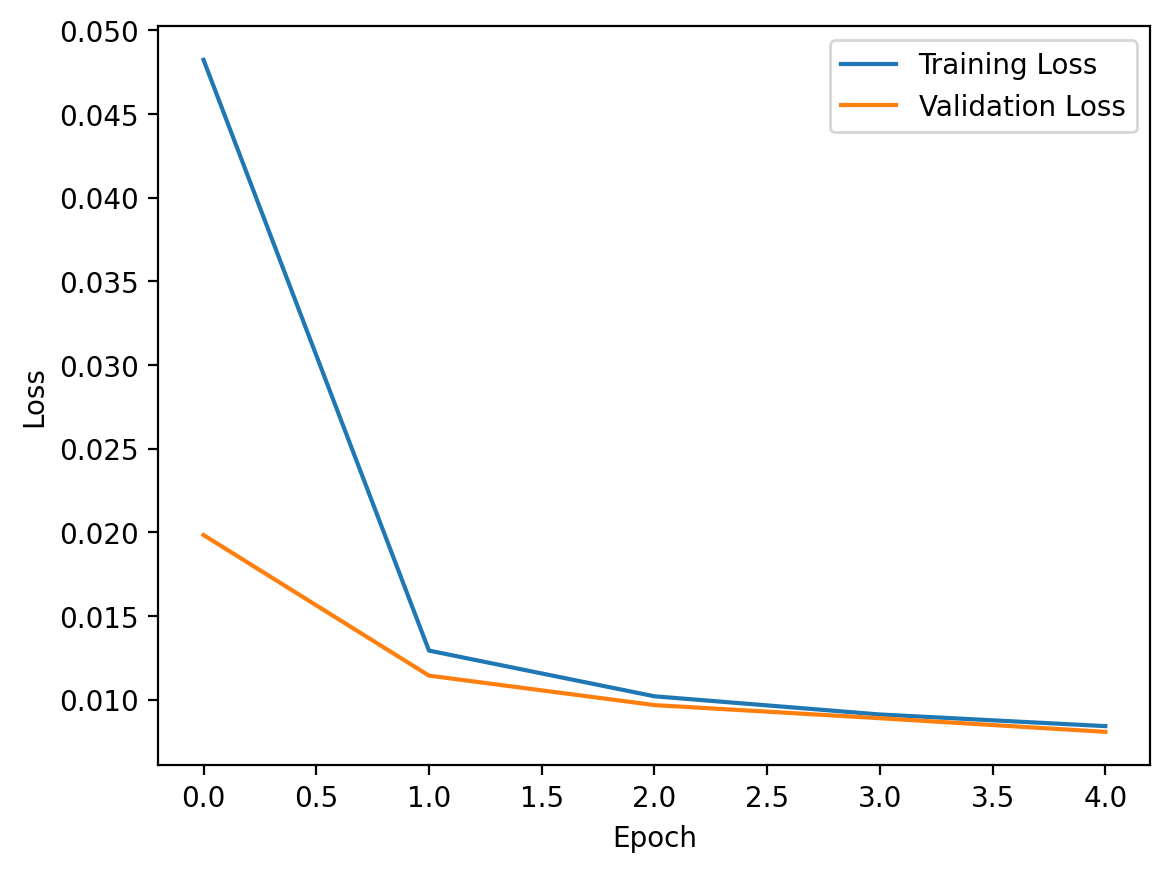

"plt.plot(model_50.loss_during_training, label='Training Loss')\nplt.plot(model_50.valid_loss_during_training, label='Validation Loss')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()\nplt.plot(model_100.loss_during_training, label='Training Loss')\nplt.plot(model_100.valid_loss_during_training, label='Validation Loss')\nplt.xlabel('Epoch')\nplt.ylabel('Loss')\nplt.legend()\nplt.show()"

In [ ]:
'''plt.plot(model_15.loss_during_training, label='Training Loss')
plt.plot(model_15.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()'''
plt.plot(model_30.loss_during_training, label='Training Loss')
plt.plot(model_30.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
'''plt.plot(model_50.loss_during_training, label='Training Loss')
plt.plot(model_50.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(model_100.loss_during_training, label='Training Loss')
plt.plot(model_100.valid_loss_during_training, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()'''

**ARQUITECTURA 5 CAPAS**


In [ ]:
import torch.nn as nn

class ConvAutoencoder5(nn.Module):
    def __init__(self, C=8, dropout_prob=0.5):
        super().__init__()

        # ---------- ENCODER ----------
        # 2 poolings (2x2) para no reducir demasiado la imagen
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv5 = nn.Conv2d(256, C, kernel_size=3, stride=1, padding=1)

        self.pool = nn.MaxPool2d(2, 2)

        # ---------- DECODER ----------
        # Ajuste de ConvTranspose2d con output_padding para reconstruir 28x28
        self.t_conv1 = nn.ConvTranspose2d(C, 256, kernel_size=2, stride=2)
        self.t_conv2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2, output_padding=0)
        self.t_conv3 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1)
        self.t_conv4 = nn.ConvTranspose2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv6 = nn.Conv2d(32, 1, kernel_size=3, stride=1, padding=1)

        # ---------- BATCHNORM ----------
        self.BN_1 = nn.BatchNorm2d(32)
        self.BN_2 = nn.BatchNorm2d(64)
        self.BN_3 = nn.BatchNorm2d(128)
        self.BN_4 = nn.BatchNorm2d(256)
        self.BN_5 = nn.BatchNorm2d(C)

        self.BN_6 = nn.BatchNorm2d(256)
        self.BN_7 = nn.BatchNorm2d(128)
        self.BN_8 = nn.BatchNorm2d(64)
        self.BN_9 = nn.BatchNorm2d(32)

        # ---------- ACTIVACIONES Y DROPOUT ----------
        self.relu = nn.ReLU()
        self.decoder_activation = nn.Tanh()
        self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, x):
        # ---------- ENCODER ----------
        x = self.conv1(x)
        x = self.BN_1(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv2(x)
        x = self.BN_2(x)
        x = self.relu(x)
        x = self.pool(x)
        x = self.dropout(x)

        x = self.conv3(x)
        x = self.BN_3(x)
        x = self.relu(x)

        x = self.conv4(x)
        x = self.BN_4(x)
        x = self.relu(x)

        x = self.conv5(x)
        x = self.BN_5(x)
        x = self.relu(x)

        latent = x

        # ---------- DECODER ----------
        x = self.t_conv1(x)
        x = self.BN_6(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.t_conv2(x)
        x = self.BN_7(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.t_conv3(x)
        x = self.BN_8(x)
        x = self.relu(x)
        x = self.dropout(x)

        x = self.t_conv4(x)
        x = self.BN_9(x)
        x = self.relu(x)

        x = self.conv6(x)
        x = self.decoder_activation(x)

        return x, latent



In [ ]:
class ConvAutoencoder_extended(ConvAutoencoder5):
    def __init__(self, epochs=10, lr=0.01, C=4):
        super().__init__(C)
        self.lr = lr
        self.optim = optim.Adam(self.parameters(), self.lr)
        self.epochs = epochs
        self.criterion = nn.MSELoss()  # Usamos el error cuadrático medio para autoencoders
        self.loss_during_training = []
        self.valid_loss_during_training = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.to(self.device)

    def trainloop(self, trainloader, validloader):
        # Bucle de entrenamiento
        for e in range(int(self.epochs)):
            running_loss = 0.
            start_time = time.time()
            for images, labels in trainloader:
                # En autoencoders, la etiqueta es la propia imagen de entrada
                labels = images
                # Movemos los tensores al dispositivo (CPU o GPU)
                images, labels = images.to(self.device), labels.to(self.device)
                self.optim.zero_grad()  # Reiniciamos los gradientes
                out = self.forward(images)[0]  # Forward pass, solo necesitamos la imagen reconstruida
                loss = self.criterion(out, labels)  # Calculamos la pérdida entre la reconstrucción y la imagen original
                running_loss += loss.item()
                loss.backward()  # Backpropagation
                self.optim.step()  # Actualizamos los pesos
            # Guardamos la pérdida media de la época
            self.loss_during_training.append(running_loss / len(trainloader))
            # Evaluamos en el conjunto de validación
            val_loss, val_psnr = self.eval_performance(validloader) # <-- Obtener ambos
            self.valid_loss_during_training.append(val_loss)
            # Mostramos información de la época
            print(f"Epoch {e}. Training loss: {self.loss_during_training[-1]:.6f}, "
                  f"Validation loss: {val_loss:.6f}, "
                  f"Validation PSNR: {val_psnr:.2f} dB")
    def eval_performance(self, dataloader):
        # Evaluación del modelo en un conjunto de datos
        self.eval()  # Modo evaluación (importante para capas como batchnorm)
        total_loss = 0.
        total_psnr = 0.
        with torch.no_grad():  # No calculamos gradientes en evaluación
            for images, labels in dataloader:
                labels = images
                images, labels = images.to(self.device), labels.to(self.device)
                out = self.forward(images)[0]
                loss = self.criterion(out, labels)
                total_loss += loss.item()
                total_psnr += psnr(labels, out).item()
        return total_loss / len(dataloader), total_psnr / len(dataloader)  # Devolvemos la pérdida media y PSNR

In [ ]:
#model_15 = ConvAutoencoder_extended(epochs=5, lr=0.001,C=15)
#model_15.trainloop(train_loader,test_loader)
model_30 = ConvAutoencoder_extended(epochs=5, lr=0.001,C=30)
model_30.trainloop(train_loader_FMNIST,test_loader_FMNIST)
#model_50 = ConvAutoencoder_extended(epochs=5, lr=0.001,C=50)
#model_50.trainloop(train_loader,test_loader)
#model_100 = ConvAutoencoder_extended(epochs=5, lr=0.001,C=100)
#model_100.trainloop(train_loader,test_loader)


Epoch 0. Training loss: 0.061969, Validation loss: 0.029139, Validation PSNR: 21.40 dB
Epoch 1. Training loss: 0.016579, Validation loss: 0.012908, Validation PSNR: 24.95 dB
